# CNN architectures {-}

This notebook aims at familiarizing you with training, validating and testing deep neural networks. Here are the BASIC requirements:

- Load the data.
- Process, normalize and resize the images.
- Build a CNN architecture of your choice (from this list of models https://www.tensorflow.org/api_docs/python/tf/keras/applications, except the VGG16 as in the demo code). Several ideas for model construction: adjust the cut-off layer position, add various types of neural network layers after the cut-off layer, etc. 
- Train and validate the CNN to perform the image classification task.
- Evaluate the performance of the model on the test set.
- Visualize the model behaviour during the training.

The dataset you will be working on is The CIFAR-10. This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow as tf 
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# PLEASE DO NOT CHANGE THIS CODE

# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 ) 
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train) 
cifar10_test = tfds.as_numpy(cifar10_test)

# Data processing and model training

In [3]:
# PLEASE DO NOT CHANGE THIS CODE

# Seperate feature X and label Y
X_train, Y_train = cifar10_train["image"], cifar10_train["label"]
X_test, Y_test = cifar10_test["image"], cifar10_test["label"]
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=99, test_size=0.2)

# Normalize the image data
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

# Specify the input image size and number of classes
img_width, img_height = 32, 32
nb_classes = 10

# Converts a class vector (integers) to binary class matrix to have one-hot encoding label. For example:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_val = np_utils.to_categorical(Y_val, nb_classes) 
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [4]:
# Your code goes here
# Initialize the model densenet from tf.keras.applications
model_densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_width, img_height, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [5]:
print("Training set shape: " + str(X_train.shape))
print("validation set shape: " + str(X_val.shape))
print("Test set shape: " + str(X_test.shape))

Training set shape: (40000, 32, 32, 3)
validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [6]:
# Print model summary
model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

In [7]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

In [16]:
# Add a global spatial average pooling layer
x = model_densenet.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)

# Add a dropout layer
x = Dropout(0.2)(x) # Add a dropout layer with probability 0.5.

# Add a final classification layer for the 10 classes in the CIFAR-10 dataset
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model_densenet_cifar10 = Model(inputs=model_densenet.input, outputs=predictions)

# Compile the model
model_densenet_cifar10.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), 
                               loss='binary_crossentropy', 
                               metrics=['accuracy'])

In [17]:
# Train the model, show training and validation performance
# model_training = model_densenet_cifar10.fit(X_train, Y_train, epochs=30, batch_size=256, validation_data=(X_val, Y_val))

# Train the model using the augmented data
model_training = model_densenet_cifar10.fit_generator(datagen.flow(X_train, Y_train, batch_size=256),
                    epochs=50,
                    validation_data=(X_val, Y_val))

Epoch 1/50


<ipython-input-17-3430f80d10e6>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_training = model_densenet_cifar10.fit_generator(datagen.flow(X_train, Y_train, batch_size=256),


157/157 [==============================] - 73s 226ms/step - loss: 0.0864 - accuracy: 0.8437 - val_loss: 0.1019 - val_accuracy: 0.8063
Epoch 2/50
157/157 [==============================] - 34s 217ms/step - loss: 0.0735 - accuracy: 0.8568 - val_loss: 0.0935 - val_accuracy: 0.8201
Epoch 3/50
157/157 [==============================] - 32s 204ms/step - loss: 0.0691 - accuracy: 0.8648 - val_loss: 0.0986 - val_accuracy: 0.8091
Epoch 4/50
157/157 [==============================] - 33s 213ms/step - loss: 0.0667 - accuracy: 0.8711 - val_loss: 0.1076 - val_accuracy: 0.7944
Epoch 5/50
157/157 [==============================] - 36s 230ms/step - loss: 0.0629 - accuracy: 0.8774 - val_loss: 0.0877 - val_accuracy: 0.8340
Epoch 6/50
157/157 [==============================] - 34s 219ms/step - loss: 0.0615 - accuracy: 0.8791 - val_loss: 0.0986 - val_accuracy: 0.8102
Epoch 7/50
157/157 [==============================] - 34s 216ms/step - loss: 0.0579 - accuracy: 0.8863 - val_loss: 0.0868 - val_accuracy: 0.8

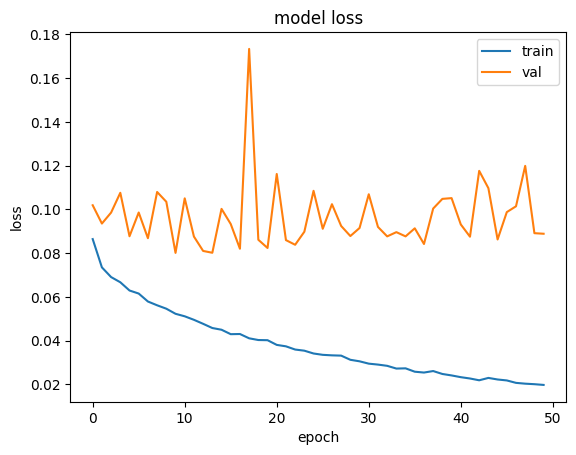

In [18]:
# Visualize the training and validation loss over epochs
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

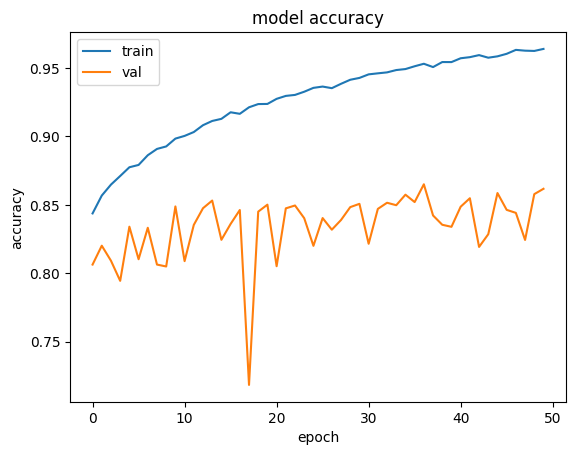

In [19]:
# Visualize the training and validation accuracy over epochs
plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model evaluation

In [20]:
# Evaluate the model prediction on a data sample
pred = model_densenet_cifar10.predict(X_test[:1]) # Make prediction on a data sample
print("Model prediction: " + str(pred)) # Model prediction
print("True label: " + str(Y_test[:1])) # True label

1/1 [==============================] - 2s 2s/step
Model prediction: [[5.0502265e-04 3.0867086e-04 4.9547929e-02 1.0303174e-02 2.1866601e-02
  1.3538264e-02 1.6715331e-02 8.8531178e-01 6.6417886e-04 1.2390425e-03]]
True label: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [21]:
# Evaluate the model prediction on the entire test set
preds = model_densenet_cifar10.predict(X_test) # Make prediction on the entire test set
preds_index = np.argmax(preds, axis=1) # Get the index of maximum class probability of each of the data sample
label_index = np.argmax(Y_test, axis=1) # Get the index of maximum class label

313/313 [==============================] - 4s 13ms/step


In [22]:
# Compare the predictions with the true labels
comparison_result = np.equal(preds_index, label_index) # Return the comparison result which is an array of True/False.

# Calculate the number of correct predictions (True values in the comparison result array).
correct_preds = comparison_result.sum() # Compute the sum of elements across dimensions of a tensor.

# Show accuracy
print("Number of correct predictions: " + str(correct_preds))
print("Test accuracy: " + str(correct_preds/X_test.shape[0]))

Number of correct predictions: 8569
Test accuracy: 0.8569


# Model evaluation using built-in Tensorflow function

In [23]:
# Evaluate the model accuracy using the function model.evaluate()
model_eval = model_densenet_cifar10.evaluate(X_test, Y_test, batch_size=4096)
print("List of metrics" + str(model_densenet_cifar10.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss 
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

3/3 [==============================] - 1s 190ms/step - loss: 0.0967 - accuracy: 0.8569
List of metrics['loss', 'accuracy']
Test loss: 0.09671879559755325
Test accuracy: 0.8568999767303467
